# Epicurious kNN Model (Classification)
- https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/
- https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
- Why kNN? 
    - Supervised classification algorithm
    - Model representation for KNN is the entire training dataset
    - KNN performs well with all data on same scale
        - Normalizing data to range [0, 1]
        - features with high magnitudes will weight more than features with low magnitudes
    - Address missing data (this is how kNN calcs the distance)
        - Excude or imput missing values
    - kNN performs well with lower dimenionality

In [5]:
import math 
from statistics import mean
import pandas as pd  
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from datetime import date
from datetime import datetime
import pylab as pl

from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.svm import SVC, SVR

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans

# Data Set
- https://www.kaggle.com/hugodarwood/epirecipes

# Data Cleaning & Preprocessing
- removed null values for rating
- removed all features and ratings with a value of zero
- removed outliers
- add ingredients count feature
- add tags counts feature
- add age of recipe feature from date
- refactor the ratings from a 5 point scale to a 4 point scale

# Read Data

In [15]:
# read data from csv
df_updated = pd.read_csv('epicurious_data_cleaned_updated.csv')

In [16]:
# set up features and target data
features = ['calories','fat','protein','sodium', 'ingredients_count', 'tags_count', 'age']
# features = ['tags_count', 'age']
X = df_updated[features].values
y = df_updated['rating_normalized'].values
df_updated.describe()

,calories,fat,protein,rating,sodium,ingredients_count,tags_count,age,rating_normalized
count,9049.000000,9049.000000,9049.000000,9049.000000,9049.000000,9049.000000,9049.000000,9049.000000,9049.000000
mean,531.129186,31.455962,24.015029,4.113231,623.802188,10.782959,12.607912,10.048893,3.290585
std,576.095958,42.460473,37.704635,0.647081,838.414120,4.674646,4.892330,3.489629,0.517665
min,13.000000,1.000000,1.000000,1.250000,1.000000,1.000000,0.000000,0.046575,1.000000
25%,232.000000,11.000000,5.000000,3.750000,135.000000,7.000000,9.000000,8.580822,3.000000
50%,389.000000,20.000000,11.000000,4.375000,363.000000,10.000000,12.000000,12.369863,3.500000
75%,644.000000,37.000000,32.000000,4.375000,798.000000,13.000000,16.000000,12.369863,3.500000
max,8858.000000,776.000000,1114.000000,5.000000,9792.000000,51.000000,33.000000,12.397260,4.000000


# Split into Training & Test Sets
- https://towardsdatascience.com/6-amateur-mistakes-ive-made-working-with-train-test-splits-916fabb421bb

In [17]:
# Split dataset into training set and test set (70% training and 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1, stratify=y)

# Feature Selection & Preprocessing
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html
- https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa

### Univariate feature selection with F-test for feature scoring

In [18]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

Text(0.5, 0, 'Feature')

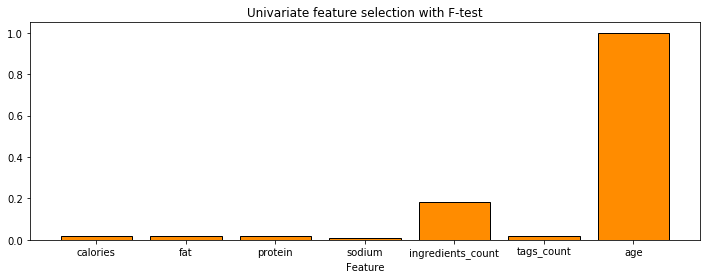

In [19]:
X_indices = np.arange(X.shape[-1])
plt.figure(figsize=(12, 4)) 
plt.xticks(X_indices, features)
plt.bar(X_indices, scores, width=0.8,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
plt.title("Univariate feature selection with F-test")
plt.xlabel("Feature")

### Encode the target for the kNN model
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
    - fit(self, y): fit label encoder
    - fit_transform(self, y): fit label encoder and return encoded labels
    - get_params(self[, deep]): get parameters for this estimator
    - inverse_transform(self, y): transform labels back to original encoding
    - set_params(self, \*\*params): set the parameters of this estimator
    - transform(self, y): transform labels to normalized encoding

In [20]:
# check shapes to make sure everything matches
X_tr_shape = str(X_train.shape)
X_ts_shape = str(X_test.shape)
y_tr_shape = str(y_train.shape)
y_ts_shape = str(y_test.shape)

print("X_train.shape: " + X_tr_shape)
print("X_test.shape: " + X_ts_shape)
print("y_train.shape: " + y_tr_shape)
print("y_test.shape: " + y_ts_shape)

X_train.shape: (6334, 7)
X_test.shape: (2715, 7)
y_train.shape: (6334,)
y_test.shape: (2715,)


In [21]:
# fit label encoder and return encoded labels
lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.fit_transform(y_test)

### Apply standard scalar to features

In [22]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [23]:
mmscaler = MinMaxScaler()
mmscaler.fit(X_train)

X_train = mmscaler.transform(X_train)
X_test = mmscaler.transform(X_test)

# Fit Model & kFold Cross Validation
- https://machinelearningmastery.com/k-fold-cross-validation/
- https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

In [24]:
# fit the model over a range of k to find the best k values
scores = []
k_range = range(1,100)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores1 = cross_val_score(knn, X_train, y_train.ravel(), cv=10)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

# Evaluate Model Performace
(Accuracy, AUC/ROC, P/R/F1, Feature Performance)
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
- ‘k’ in KNN is a parameter that refers to the number of nearest neighbours to include in the majority of the voting process.

### Accuracy

Text(0, 0.5, 'Model Accuracy')

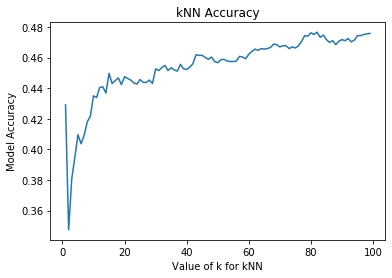

In [25]:
plt.plot(k_range, scores)
plt.title("kNN Accuracy")
plt.xlabel('Value of k for kNN')
plt.ylabel('Model Accuracy')

### Test Accuracy (f1)

In [56]:
kfold_Value = mean(scores1)
kfold_Value

0.4701633600948864

### Classification Report

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       215
           4       0.36      0.08      0.13       742
           5       0.49      0.87      0.63      1250
           6       0.43      0.35      0.38       404

    accuracy                           0.48      2715
   macro avg       0.18      0.19      0.16      2715
weighted avg       0.39      0.48      0.38      2715



# kNN Summary
- Classification accuracy without selecting features: 0.47
- Classification accuracy after univariate feature selection: 0.47

    - Split Data & Stratify
    - Same random seed across all models
    - Univariate Feature Selection (age was significant feature)
    - Label Encoding on target for classes
    - Min/Max Scalar to shape all feature scales to 1
    - Iterated to find best kFolds
    - Used kFolds to validate accuracy overall accuracy of model

# Conclusions
- Accuracy of all models were not great because the classes won't separate, artifact of unbalanced data

- Future Considerations
    - Collect more data by scraping Epicurious
    - Evaluate with different metrics: AUC/ROC
    - Resample data (trying different ratios of classes to each other, not just 1:1): 
        - https://github.com/scikit-learn-contrib/imbalanced-learn
        - Over-Sampling, Imputing, SMOTE (< 10k records): add copies of instances from the under-represented class
        - Under-Sampling: delete instances from the over-represented class
        - Stratifying data in different ways
    - Try different models (unsupervised learning, kMeans)